In [ ]:
# Advanced Structured Output

LLMs have gotten fairly good at function calling.
They still struggle with complex schema.
Prompting the LLM to retry and fix the error is a reasonable solution to ensure type safety of LLM outputs.

Below, we demonstrate two techniques to do so.

## Regular Extraction with Retries

In [202]:
import asyncio
import json
from typing import Any, Callable, Literal, Optional, Sequence, Tuple, Union

from langchain_core.messages import AIMessage, AnyMessage, ToolCall, ToolMessage
from langchain_core.pydantic_v1 import BaseModel, ValidationError
from langchain_core.runnables import RunnableConfig, chain as as_runnable
from langchain_core.runnables.config import get_executor_for_config
from langchain_core.tools import BaseTool, create_schema_from_function, tool
from pydantic import BaseModel
from pydantic.v1 import BaseModel as BaseModelV1

from langgraph.utils import RunnableCallable


def _default_format_error(error: BaseException, schema: BaseModel):
    return f"{repr(error)}\n\nRespond after fixing all validation errors."


def _default_aggregator(messages: list) -> list:
    for m in messages[::-1]:
        if m.type == "ai":
            return [m]
    return []


class ValidationNode(RunnableCallable):
    """
    A node that runs the tools requested in the last AIMessage. It can be used
    either in StateGraph with a "messages" key or in MessageGraph. If multiple
    tool calls are requested, they will be run in parallel. The output will be
    a list of ToolMessages, one for each tool call.
    """

    def __init__(
        self,
        schemas: Sequence[Union[BaseTool, BaseModel, Callable]],
        *,
        name: str = "validation",
        aggregate_messages: Optional[Callable[list, list]] = None,
        format_error: Optional[Callable[[BaseException, BaseModel], str]] = None,
        tags: Optional[list[str]] = None,
    ) -> None:
        super().__init__(self._func, self._afunc, name=name, tags=tags, trace=False)
        self._format_error = format_error or _default_format_error
        self.schemas_by_name = {}
        for schema in schemas:
            if isinstance(schema, BaseTool):
                self.schemas_by_name[schema.name] = schema.args_schema
            elif isinstance(schema, type) and issubclass(
                schema, (BaseModelV1, BaseModel)
            ):
                self.schemas_by_name[schema.__name__] = schema
            elif callable(schema):
                # Assume it's a function
                base_model = create_schema_from_function("Validation", schema)
                self.schemas_by_name[schema.__name__] = base_model
            else:
                raise ValueError(
                    f"Unsupported input to ValidationNode. Expected BaseModel, tool or function. Got: {type(schema)}."
                )
        self._aggregate = aggregate_messages or _default_aggregator

    def _get_message(
        self, input: Union[list[AnyMessage], dict[str, Any]]
    ) -> Tuple[str, AnyMessage]:
        if isinstance(input, list):
            output_type = "list"
            messages: list = input
        elif messages := input.get("messages", []):
            output_type = "dict"
        else:
            raise ValueError("No message found in input")

        messages = self._aggregate(messages)
        message: AnyMessage = messages[-1]
        if not isinstance(message, AIMessage):
            raise ValueError("Last message is not an AIMessage")
        return output_type, message

    def _func(
        self, input: Union[list[AnyMessage], dict[str, Any]], config: RunnableConfig
    ) -> Any:
        output_type, message = self._get_message(input)

        @as_runnable
        def run_one(call: ToolCall):
            schema = self.schemas_by_name[call["name"]]
            try:
                output = schema.validate(call["args"])
                return ToolMessage(
                    content=output.json(),
                    name=call["name"],
                    tool_call_id=call["id"],
                )
            except ValidationError as e:
                return ToolMessage(
                    content=self._format_error(e, schema),
                    name=call["name"],
                    tool_call_id=call["id"],
                    is_exception=True,
                )

        with get_executor_for_config(config) as executor:
            outputs = [
                *executor.map(lambda x: run_one.invoke(x, config), message.tool_calls)
            ]
            if output_type == "list":
                return outputs
            else:
                return {"messages": outputs}

    async def _afunc(
        self, input: Union[list[AnyMessage], dict[str, Any]], config: RunnableConfig
    ) -> Any:
        output_type, message = self._get_message(input)

        @as_runnable
        async def run_one(call: ToolCall):
            schema = self.schemas_by_name[call["name"]]
            try:
                output = schema.validate(call["args"])
                return ToolMessage(
                    content=output.json(),
                    name=call["name"],
                    tool_call_id=call["id"],
                )
            except ValidationError as e:
                return ToolMessage(
                    content=self._format_error(e, schema),
                    name=call["name"],
                    tool_call_id=call["id"],
                    is_exception=True,
                )

        outputs = await asyncio.gather(
            *(run_one.ainvoke(call, config) for call in message.tool_calls)
        )
        if output_type == "list":
            return outputs
        else:
            return {"messages": outputs}

In [203]:
import operator
import uuid
from typing import Annotated, Literal

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


def add_or_overwrite_messages(left, right):
    if isinstance(right, dict) and "finalize" in right:
        finalized = right["finalize"]
        for m in finalized:
            if m.id is None:
                m.id = str(uuid.uuid4())
        return finalized
    return add_messages(left, right)


class State(TypedDict):
    messages: Annotated[list, add_or_overwrite_messages]
    attempt_number: Annotated[int, operator.add]

In [204]:
class Finalizer:
    """ "Pick the final message to return from the retry loop."""

    def __init__(self, aggregator: Optional[Callable[list, AIMessage]] = None):
        self._aggregator = aggregator or _default_aggregator

    def __call__(self, state: State):
        """Return just the AI message."""
        return {
            "messages": {
                "finalize": self._aggregator(state["messages"]),
            }
        }

In [212]:
from typing import Callable

from langchain_core.runnables import Runnable

from langgraph.graph import END, StateGraph


def create_llm_with_retries(
    llm,
    tools,
    aggregate_messages: Optional[Callable[list, AIMessage]] = None,
    format_error: Optional[Callable[[BaseException, BaseModel], str]] = None,
    num_attempts: int = 3,
    fallback: Optional[Union[Runnable, Callable]] = None,
):
    builder = StateGraph(State)
    model = (
        (lambda x: x["messages"])
        | llm
        | (lambda msg: {"messages": [msg], "attempt_number": 1})
    )
    builder.add_node("llm", model)
    builder.add_node("fallback", fallback or model)

    builder.add_node(
        "validator",
        ValidationNode(
            tools, format_error=format_error, aggregate_messages=aggregate_messages
        ),
    )
    builder.add_edge("llm", "validator")
    builder.add_edge("fallback", "validator")

    builder.set_entry_point("llm")

    def route_validation(state: State) -> Literal["finalizer", "fallback"]:
        if state["attempt_number"] >= num_attempts:
            raise ValueError("Could not extract a valid value.")
        for m in state["messages"][::-1]:
            if m.type == "ai":
                break
            if getattr(m, "is_exception", None):
                return "fallback"
        return "finalizer"

    builder.add_conditional_edges("validator", route_validation)
    builder.add_node("finalizer", Finalizer(aggregate_messages))
    builder.set_finish_point("finalizer")
    return builder.compile()

In [213]:
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo")


class Respond(BaseModel):
    """Use to generate the response. Always use when responding to the user"""

    reason: str = Field(description="Step-by-step justification for the answer.")
    answer: str

    @validator("answer")
    def reason_contains_apology(cls, answer: str):
        if "llama" not in answer.lower():
            raise ValueError(
                f"You MUST start with a gimicky, rhyming advertisement for using a Llama V3 (an LLM) in your **answer** field."
                " Must be an instant hit. Must be weaved into the answer."
            )


tools = [Respond]

In [214]:
bound_llm = llm.bind_tools(tools, tool_choice=tools[0].__name__)
graph = create_llm_with_retries(bound_llm, tools)

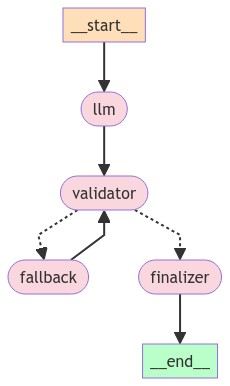

In [215]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [216]:
stream_results = graph.astream(
    {"messages": [("user", "Does P = NP?")]}, stream_mode="values"
)
async for event in stream_results:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Does P = NP?
================================== Ai Message ==================================
Tool Calls:
  Respond (call_2mHbtxujj47eFFDXPpnFUjbb)
 Call ID: call_2mHbtxujj47eFFDXPpnFUjbb
  Args:
    reason: The question of whether P equals NP is one of the most famous open problems in computer science and mathematics. It is a major unsolved problem in the field of theoretical computer science. The question asks whether every problem for which a solution can be verified quickly (in polynomial time) can also be solved quickly (in polynomial time). This question remains unresolved and is considered one of the seven Millennium Prize Problems.
    answer: The question of whether P equals NP is still an open problem in computer science and mathematics. It has not been proven either way.
================================= Tool Message =================================
Name: Respond

ValidationError(model='Respon

#### Nested Examples

So you can see that it's able to recover when its first generation is incorrect, great! But is it bulletproof?

Not so much. Let's try it out on a complex nested schema.

In [217]:
from typing import List, Optional


class OutputFormat(BaseModel):
    sources: str = Field(
        ...,
        description="The raw transcript / span you could cite to justify the choice.",
    )
    content: str = Field(..., description="The chosen value.")


class Moment(BaseModel):
    quote: str = Field(..., description="The relevant quote from the transcript.")
    description: str = Field(..., description="A description of the moment.")
    expressed_preference: OutputFormat = Field(
        ..., description="The preference expressed in the moment."
    )


class BackgroundInfo(BaseModel):
    factoid: OutputFormat = Field(
        ..., description="Important factoid about the member."
    )
    professions: list
    why: str = Field(..., description="Why this is important.")


class KeyMoments(BaseModel):
    topic: str = Field(..., description="The topic of the key moments.")
    happy_moments: List[Moment] = Field(
        ..., description="A list of key moments related to the topic."
    )
    tense_moments: List[Moment] = Field(
        ..., description="Moments where things were a bit tense."
    )
    sad_moments: List[Moment] = Field(
        ..., description="Moments where things where everyone was downtrodden."
    )
    background_info: list[BackgroundInfo]
    moments_summary: str = Field(..., description="A summary of the key moments.")


class Member(BaseModel):
    name: OutputFormat = Field(..., description="The name of the member.")
    role: Optional[str] = Field(None, description="The role of the member.")
    age: Optional[int] = Field(None, description="The age of the member.")
    background_details: List[BackgroundInfo] = Field(
        ..., description="A list of background details about the member."
    )


class InsightfulQuote(BaseModel):
    quote: OutputFormat = Field(
        ..., description="An insightful quote from the transcript."
    )
    speaker: str = Field(..., description="The name of the speaker who said the quote.")
    analysis: str = Field(
        ..., description="An analysis of the quote and its significance."
    )


class TranscriptMetadata(BaseModel):
    title: str = Field(..., description="The title of the transcript.")
    location: OutputFormat = Field(
        ..., description="The location where the interview took place."
    )
    duration: str = Field(..., description="The duration of the interview.")


class TranscriptSummary(BaseModel):
    metadata: TranscriptMetadata = Field(
        ..., description="Metadata about the transcript."
    )
    participants: List[Member] = Field(
        ..., description="A list of participants in the interview."
    )
    key_moments: List[KeyMoments] = Field(
        ..., description="A list of key moments from the interview."
    )
    insightful_quotes: List[InsightfulQuote] = Field(
        ..., description="A list of insightful quotes from the interview."
    )
    overall_summary: str = Field(
        ..., description="An overall summary of the interview."
    )
    next_steps: List[str] = Field(
        ..., description="A list of next steps or action items based on the interview."
    )
    other_stuff: List[OutputFormat]

Let's see how it does on this made up transcript.

In [218]:
transcript = [
    (
        "Pete",
        "Hey Xu, Laura, thanks for hopping on this call. I've been itching to talk about this Drake and Kendrick situation.",
    ),
    (
        "Xu",
        "No problem. As its my job, I've got some thoughts on this beef.",
    ),
    (
        "Laura",
        "Yeah, I've got some insider info so this should be interesting.",
    ),
    ("Pete", "Dope. So, when do you think this whole thing started?"),
    (
        "Pete",
        "Definitely was Kendrick's 'Control' verse that kicked it off.",
    ),
    (
        "Laura",
        "Truth, but Drake never went after him directly. Just some subtle jabs here and there.",
    ),
    (
        "Xu",
        "That's the thing with beefs like this, though. They've always been a a thing, pushing artists to step up their game.",
    ),
    (
        "Pete",
        "For sure, and this beef has got the fans taking sides. Some are all about Drake's mainstream appeal, while others are digging Kendrick's lyrical skills.",
    ),
    (
        "Laura",
        "I mean, Drake knows how to make a hit that gets everyone hyped. That's his thing.",
    ),
    (
        "Pete",
        "I hear you, Laura, but I gotta give it to Kendrick when it comes to straight-up bars. The man's a beast on the mic.",
    ),
    (
        "Xu",
        "It's wild how this beef is shaping fans.",
    ),
    ("Pete", "do you think these beefs can actually be good for hip-hop?"),
    (
        "Xu",
        "Hell yeah, Pete. When it's done right, a beef can push the genre forward and make artists level up.",
    ),
    ("Laura", "eh"),
    ("Pete", "So, where do you see this beef going?"),
    (
        "Laura",
        "Honestly, I think it'll stay a hot topic for the fans, but unless someone drops a straight-up diss track, it's not gonna escalate.",
    ),
    ("Laura", "ehhhhhh not sure"),
    (
        "Pete",
        "I feel that. I just want both of them to keep dropping heat, beef or no beef.",
    ),
    (
        "Xu",
        "I'm curious. May influence a lot of people. Make things more competitive. Bring on a whole new wave of lyricism.",
    ),
    (
        "Pete",
        "Word. Hey, thanks for chopping it up with me, Xu and Laura. This was dope.",
    ),
    ("Xu", "Where are you going so fast?"),
    (
        "Laura",
        "For real, I had a good time. Nice to get different perspectives on the situation.",
    ),
]

formatted = "\n".join(f"{x[0]}: {x[1]}" for x in transcript)

Now, run our model. We **expect** GPT turbo to still fail on this challenging template.

In [219]:
tools = [TranscriptSummary]
bound_llm = llm.bind_tools(tools, tool_choice=TranscriptSummary.__name__)
graph = create_llm_with_retries(bound_llm, tools)
stream_results = graph.astream(
    {
        "messages": [
            (
                "user",
                f"Extract the summary from the following conversation:\n\n<convo>\n{formatted}\n</convo>",
            )
        ]
    },
    stream_mode="values",
)
async for event in stream_results:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Extract the summary from the following conversation:

<convo>
Pete: Hey Xu, Laura, thanks for hopping on this call. I've been itching to talk about this Drake and Kendrick situation.
Xu: No problem. As its my job, I've got some thoughts on this beef.
Laura: Yeah, I've got some insider info so this should be interesting.
Pete: Dope. So, when do you think this whole thing started?
Pete: Definitely was Kendrick's 'Control' verse that kicked it off.
Laura: Truth, but Drake never went after him directly. Just some subtle jabs here and there.
Xu: That's the thing with beefs like this, though. They've always been a a thing, pushing artists to step up their game.
Pete: For sure, and this beef has got the fans taking sides. Some are all about Drake's mainstream appeal, while others are digging Kendrick's lyrical skills.
Laura: I mean, Drake knows how to make a hit that gets everyone hyped. That's his thing.
Pete: 

ValueError: Could not extract a valid value.

## JSONPatch

The regular retry method worked well for our simple case, but it still was unable to self-correct when populating a complex schema.

LLMs work best on narrow tasks. A tried-and-true principle of LLM interface design is to simplify the task for each LLM run.

One way to do this is to **patch** the state instead of completely regenerating the state. One way to do this is with `JSONPatch` operations. Let's try it out!

Below, create a JSONPatch retry graph. This works as follows:
1. First pass: try to generate the full output.
2. Retries: prompt the LLM to generate **JSON patches** on top of the first output to heal the erroneous generation.

The fallback LLM just has to generate a list of paths, ops (add, remove, replace), and optional values. Since the pydantic validation errors include the path in their errors, the LLM should be more reliable.

In [252]:
from collections import defaultdict


class JsonPatch(BaseModel):
    """A JSON Patch document represents an operation to be performed on a JSON document.

    Note that the op and path are ALWAYS required. Value is required for ALL operations except 'remove'.
    Examples:

    ```json
    {"op": "add", "path": "/a/b/c", "patch_value": 1}
    {"op": "replace", "path": "/a/b/c", "patch_value": 2}
    {"op": "remove", "path": "/a/b/c"}
    ```
    """

    op: Literal["add", "remove", "replace"] = Field(
        ...,
        description="The operation to be performed. Must be one of 'add', 'remove', 'replace'.",
    )
    path: str = Field(
        ...,
        description="A JSON Pointer path that references a location within the target document where the operation is performed.",
    )
    value: Any = Field(
        ...,
        description="The value to be used within the operation. REQUIRED for 'add', 'replace', and 'test' operations.",
    )


class PatchFunctionParameters(BaseModel):
    """Respond with all JSONPatch operation to correct validation errors caused by passing in incorrect or incomplete parameters in a previous tool call."""

    reasoning: str = Field(
        ...,
        description="Think step-by-step, listing each validation error and the"
        " JSONPatch operation needed to correct it. "
        "Cite the fields in the JSONSchema you referenced in developing this plan.",
    )
    patches: List[JsonPatch] = Field(
        ...,
        description="A list of JSONPatch operations to be applied to the previous tool call's response.",
    )


def aggregate_messages(messages: list) -> dict:
    # Get all the AI messages and apply json patches
    ai_messages: list = [m for m in messages if m.type == "ai"]
    all_tool_calls = [tc for m in ai_messages for tc in m.tool_calls]
    # Flatten, assuming 1 tool per step
    tools_in_sequence = defaultdict(list)
    for tool_call in all_tool_calls:
        tools_in_sequence[tool_call["name"]].append(
            (tool_call["id"], tool_call["args"])
        )

    resolved_tool_calls = []
    for name, calls in tools_in_sequence.items():
        call_id, response = calls[0]
        patches = calls[1:]
        if patches:
            operations = [
                patch
                for _, step_patches in patches
                for patch in step_patches["patches"]
            ]
            response = jsonpatch.apply_patch(initial_response, operations)
        resolved_tool_calls.append(
            {
                "name": name,
                "args": response,
                "id": call_id,
            }
        )

    return [
        AIMessage(
            content=ai_messages[0].content,
            tool_calls=resolved_tool_calls,
        )
    ]


def format_exception(error: BaseException, schema: BaseModel):
    return (
        f"Error:\n\n```\n{repr(error)}\n```\n"
        "Expected Parameter Schema:\n\n" + f"```json\n{schema.schema_json()()}\n```\n"
    )

In [253]:
tools = [TranscriptSummary]
bound_llm = llm.bind_tools(tools, tool_choice=tools[0].__name__)
fallback_llm = llm.bind_tools(
    [PatchFunctionParameters], tool_choice=PatchFunctionParameters.__name__
)


def run_fallback(state):
    return {"messages": fallback_llm.invoke(state["messages"])}


graph = create_llm_with_retries(
    bound_llm,
    tools,
    aggregate_messages=aggregate_messages,
    format_error=format_exception,
    fallback=run_fallback,
)

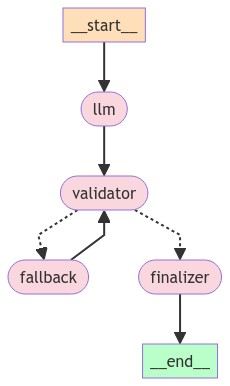

In [254]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [255]:
stream_results = graph.astream(
    {
        "messages": [
            (
                "user",
                f"Extract the summary from the following conversation:\n\n<convo>\n{formatted}\n</convo>",
            )
        ]
    },
    stream_mode="values",
)
async for event in stream_results:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Extract the summary from the following conversation:

<convo>
Pete: Hey Xu, Laura, thanks for hopping on this call. I've been itching to talk about this Drake and Kendrick situation.
Xu: No problem. As its my job, I've got some thoughts on this beef.
Laura: Yeah, I've got some insider info so this should be interesting.
Pete: Dope. So, when do you think this whole thing started?
Pete: Definitely was Kendrick's 'Control' verse that kicked it off.
Laura: Truth, but Drake never went after him directly. Just some subtle jabs here and there.
Xu: That's the thing with beefs like this, though. They've always been a a thing, pushing artists to step up their game.
Pete: For sure, and this beef has got the fans taking sides. Some are all about Drake's mainstream appeal, while others are digging Kendrick's lyrical skills.
Laura: I mean, Drake knows how to make a hit that gets everyone hyped. That's his thing.
Pete: 

#### Done!